<a href="https://colab.research.google.com/github/neetinds/Capstone3/blob/main/Capstone3_Data_science_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To identify the factors that lead to attrition with the goal of building a model that uses credentials of the candidate and various demographics factors to predict the probability of a candidate to look out for new jobs or remain at the company. 
#Using modeling technique like clustering, classification, smote, xgboost-classifier etc.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
train=pd.read_csv('/content/gdrive/MyDrive/Springboard-master/Capstone 3/aug_train.csv')
train=train.sample(frac=1,random_state=10).reset_index().drop('index',axis=1)
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,20753,city_1,0.847,Male,No relevent experience,Full time course,High School,NaN,4,10000+,Pvt Ltd,1,114,0.0
1,27035,city_167,0.921,Male,Has relevent experience,Full time course,Masters,STEM,5,100-500,Pvt Ltd,1,10,0.0
2,21753,city_21,0.624,Female,Has relevent experience,no_enrollment,Graduate,STEM,3,10000+,Pvt Ltd,1,214,0.0
3,27579,city_97,0.925,Male,Has relevent experience,Full time course,Graduate,STEM,9,100-500,Public Sector,1,111,0.0
4,22405,city_16,0.910,Male,Has relevent experience,no_enrollment,Graduate,STEM,9,500-999,Pvt Ltd,4,60,0.0


In [5]:
train.shape

(19158, 14)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

### Null/missing values

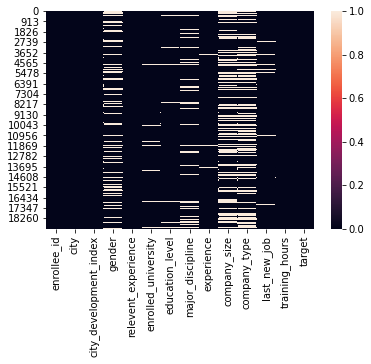

In [7]:
# Total Null values in the data set
sns.heatmap(train.isnull())
plt.show()

In [8]:
# Proportion of Null values in each column
propnull=train.isnull().sum()/len(train)
propnull

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

In [9]:
# Removing samples with null values in columns containing less than 10% null values
sub=propnull[(propnull>0) & (propnull<0.1)].index
train.dropna(subset=sub,inplace=True)
train.shape

(18014, 14)

### EDA, Feature Engineering and Data Preprocessing

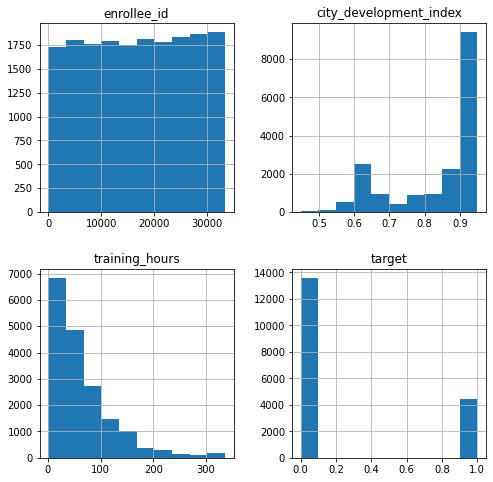

In [10]:
train.hist(figsize=(8,8))
plt.show()

###### Numeric data

In [11]:
# Numeric Columns
num=train.select_dtypes(include='number')
num.head()

,enrollee_id,city_development_index,training_hours,target
0,20753,0.847,114,0.0
1,27035,0.921,10,0.0
2,21753,0.624,214,0.0
3,27579,0.925,111,0.0
4,22405,0.910,60,0.0


In [12]:
num.shape

(18014, 4)

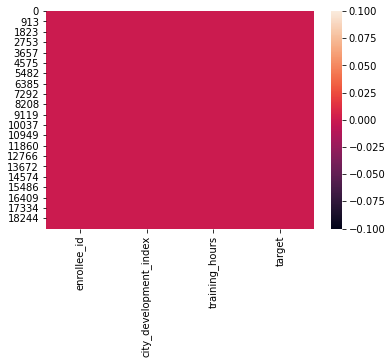

In [13]:
# Checking for null values
sns.heatmap(num.isnull())
plt.show()

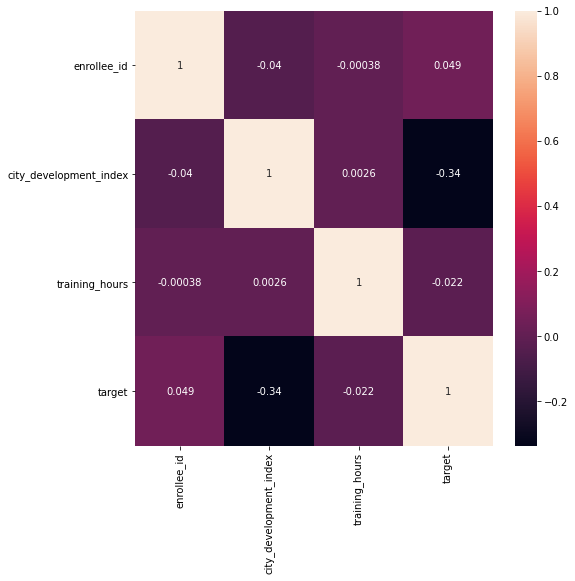

In [14]:
# Correlation for checking multicollinearity in numeric data and looking out for features having high impact on target
plt.figure(figsize=(8,8))
sns.heatmap(num.corr(),annot=True)
plt.show()

In [15]:
# Checking for duplicates in Enrollee ID (Id-Variable)
num['enrollee_id'].nunique()==len(train)

True

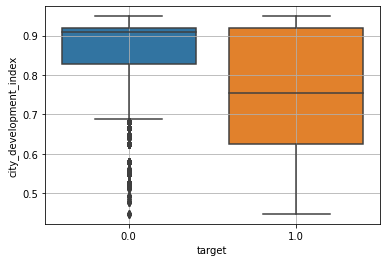

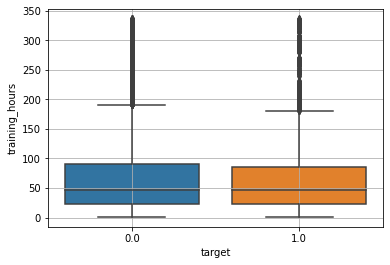

In [16]:
# Bivariate analysis of numeric features(after droping target and Id-variable) with target

n=num.drop(['target','enrollee_id'],axis=1) # Numeric features after droping target and Id-variable
for i in n:
    sns.boxplot(num['target'],n[i])
    plt.grid()
    plt.show()

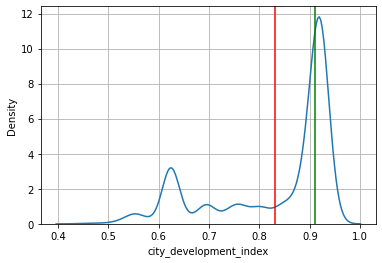

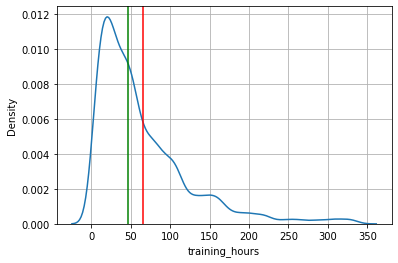

In [17]:
# Univariate analysis of numeric features after droping target and Id-variable
for i in n.columns: 
    sns.distplot(n[i],hist=False)
    plt.axvline(np.mean(n[i]),color='red')
    plt.axvline(np.median(n[i]),color='green')
    
    plt.grid()
    plt.show()

In [18]:
# Checking minimum to look out for missing values
n.describe()    

,city_development_index,training_hours
count,18014.000000,18014.000000
mean,0.831728,65.347896
std,0.122115,60.059220
min,0.448000,1.000000
25%,0.745000,23.000000
50%,0.910000,47.000000
75%,0.920000,88.000000
max,0.949000,336.000000


In [19]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,20753,city_1,0.847,Male,No relevent experience,Full time course,High School,NaN,4,10000+,Pvt Ltd,1,114,0.0
1,27035,city_167,0.921,Male,Has relevent experience,Full time course,Masters,STEM,5,100-500,Pvt Ltd,1,10,0.0
2,21753,city_21,0.624,Female,Has relevent experience,no_enrollment,Graduate,STEM,3,10000+,Pvt Ltd,1,214,0.0
3,27579,city_97,0.925,Male,Has relevent experience,Full time course,Graduate,STEM,9,100-500,Public Sector,1,111,0.0
4,22405,city_16,0.910,Male,Has relevent experience,no_enrollment,Graduate,STEM,9,500-999,Pvt Ltd,4,60,0.0


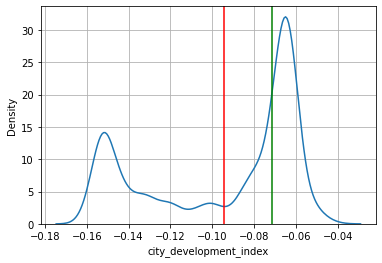

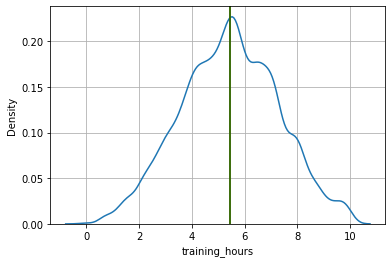

In [20]:
# Trying Boxcox tranformation on the numeric features to check skewness and distribution
import scipy.stats as stats
for i in n.columns:
    sns.distplot(stats.boxcox(n[i])[0],hist=False)
    plt.axvline(np.mean(stats.boxcox(n[i])[0]),color='red')
    plt.axvline(np.median(stats.boxcox(n[i])[0]),color='green')
    
    plt.xlabel(i)
    plt.grid()
    plt.show()

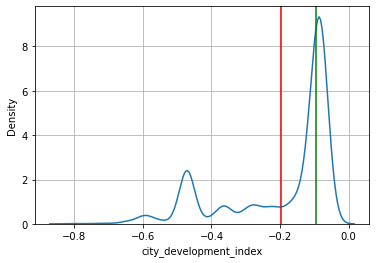

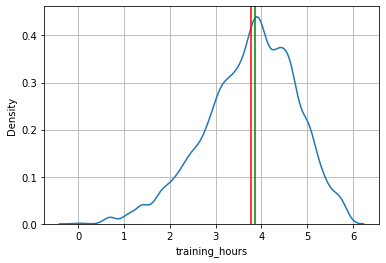

In [21]:
# Trying Log tranformation on the numeric features to check skewness and distribution
for i in n.columns:
    sns.distplot(np.log(n[i]),hist=False)
    plt.axvline(np.mean(np.log(n[i])),color='red')
    plt.axvline(np.median(np.log(n[i])),color='green')
    
    plt.xlabel(i)
    plt.grid()
    plt.show()

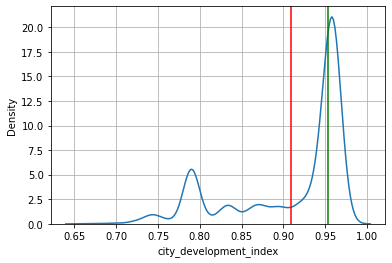

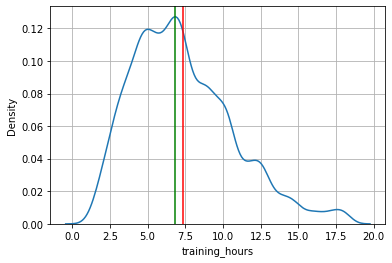

In [22]:
# Trying sqrt tranformation on the numeric features to check skewness and distribution
for i in n.columns:
    sns.distplot(np.sqrt(n[i]),hist=False)
    plt.axvline(np.mean(np.sqrt(n[i])),color='red')
    plt.axvline(np.median(np.sqrt(n[i])),color='green')
    
    plt.xlabel(i)
    plt.grid()
    plt.show()

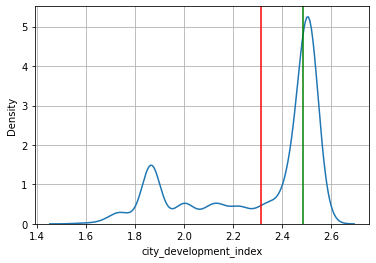

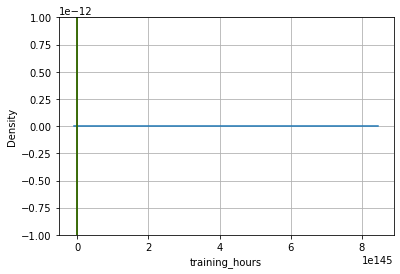

In [23]:
# Trying exponential tranformation on the numeric features to check skewness and distribution
for i in n.columns:
    sns.distplot(np.exp(n[i]),hist=False)
    plt.axvline(np.mean(np.exp(n[i])),color='red')
    plt.axvline(np.median(np.exp(n[i])),color='green')
    
    plt.xlabel(i)
    plt.grid()
    plt.show()

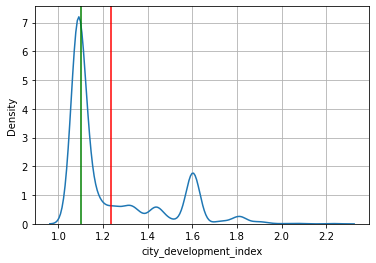

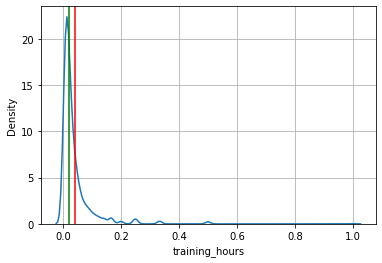

In [24]:
# Trying inverse tranformation on the numeric features to check skewness and distribution
for i in n.columns:
    sns.distplot(1/n[i],hist=False)
    plt.axvline(np.mean(1/n[i]),color='red')
    plt.axvline(np.median(1/n[i]),color='green')
    
    plt.xlabel(i)
    plt.grid()
    plt.show()

In [25]:
# Transforming the numeric features (target and id variable not included) using Boxcox Transformation
for i in n:
    n[i]=stats.boxcox(n[i])[0]
n.head()

,city_development_index,training_hours
0,-0.103387,7.304179
1,-0.064359,2.823142
2,-0.151783,8.801794
3,-0.061730,7.244260
4,-0.071285,5.935420


In [26]:
# Updating these transformations onto the train set
for i in n.columns:
    train[i]=n[i]
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,20753,city_1,-0.103387,Male,No relevent experience,Full time course,High School,NaN,4,10000+,Pvt Ltd,1,7.304179,0.0
1,27035,city_167,-0.064359,Male,Has relevent experience,Full time course,Masters,STEM,5,100-500,Pvt Ltd,1,2.823142,0.0
2,21753,city_21,-0.151783,Female,Has relevent experience,no_enrollment,Graduate,STEM,3,10000+,Pvt Ltd,1,8.801794,0.0
3,27579,city_97,-0.061730,Male,Has relevent experience,Full time course,Graduate,STEM,9,100-500,Public Sector,1,7.244260,0.0
4,22405,city_16,-0.071285,Male,Has relevent experience,no_enrollment,Graduate,STEM,9,500-999,Pvt Ltd,4,5.935420,0.0


In [27]:
# Scalling these transformed numeric features
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

train[n.columns]=sc.fit_transform(train[n.columns])
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,20753,city_1,-0.244037,Male,No relevent experience,Full time course,High School,NaN,4,10000+,Pvt Ltd,1,1.011196,0.0
1,27035,city_167,0.825214,Male,Has relevent experience,Full time course,Masters,STEM,5,100-500,Pvt Ltd,1,-1.418698,0.0
2,21753,city_21,-1.569897,Female,Has relevent experience,no_enrollment,Graduate,STEM,3,10000+,Pvt Ltd,1,1.823295,0.0
3,27579,city_97,0.897221,Male,Has relevent experience,Full time course,Graduate,STEM,9,100-500,Public Sector,1,0.978704,0.0
4,22405,city_16,0.635462,Male,Has relevent experience,no_enrollment,Graduate,STEM,9,500-999,Pvt Ltd,4,0.268970,0.0


In [28]:
train.shape

(18014, 14)

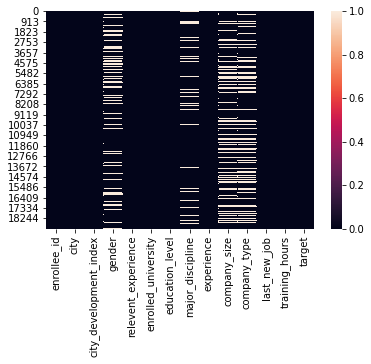

In [29]:
sns.heatmap(train.isnull())
plt.show()

In [30]:
train.isnull().sum()/len(train)

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.214444
relevent_experience       0.000000
enrolled_university       0.000000
education_level           0.000000
major_discipline          0.123349
experience                0.000000
company_size              0.294771
company_type              0.303986
last_new_job              0.000000
training_hours            0.000000
target                    0.000000
dtype: float64

### Categoric Data

In [31]:
categ=train.select_dtypes(include='object')
categ.head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
0,city_1,Male,No relevent experience,Full time course,High School,NaN,4,10000+,Pvt Ltd,1
1,city_167,Male,Has relevent experience,Full time course,Masters,STEM,5,100-500,Pvt Ltd,1
2,city_21,Female,Has relevent experience,no_enrollment,Graduate,STEM,3,10000+,Pvt Ltd,1
3,city_97,Male,Has relevent experience,Full time course,Graduate,STEM,9,100-500,Public Sector,1
4,city_16,Male,Has relevent experience,no_enrollment,Graduate,STEM,9,500-999,Pvt Ltd,4


In [32]:
categ.shape

(18014, 10)

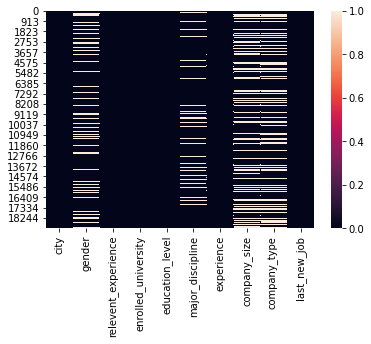

In [33]:
sns.heatmap(categ.isnull())
plt.show()

In [34]:
# Proprtion of null in each feature
propnc=categ.isnull().sum()/len(train)
propnc

city                   0.000000
gender                 0.214444
relevent_experience    0.000000
enrolled_university    0.000000
education_level        0.000000
major_discipline       0.123349
experience             0.000000
company_size           0.294771
company_type           0.303986
last_new_job           0.000000
dtype: float64

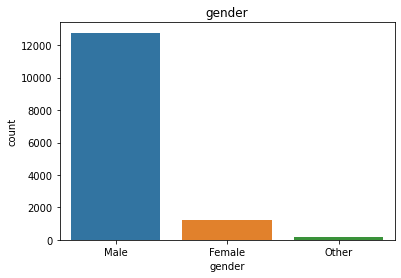

        Proportion % 
Male        70.900411
Female       6.694793
Other        0.960364


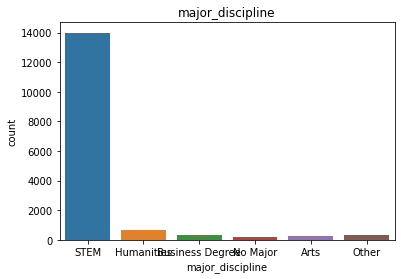

                 Proportion % 
STEM                 77.678472
Humanities            3.624958
Other                 2.020651
Business Degree       1.787499
Arts                  1.376707
No Major              1.176862


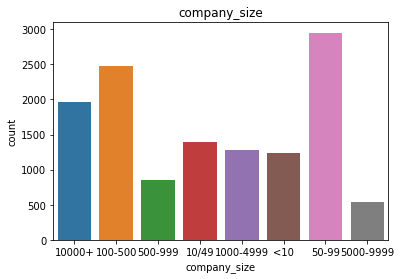

           Proportion % 
50-99          16.376152
100-500        13.783724
10000+         10.902631
10/49           7.738426
1000-4999       7.116687
<10             6.894638
500-999         4.701899
5000-9999       3.008771


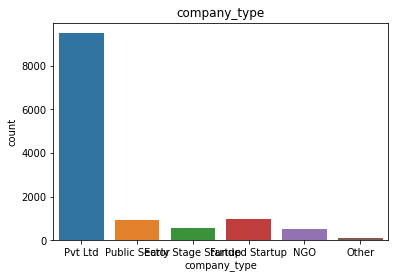

                     Proportion % 
Pvt Ltd                  52.597979
Funded Startup            5.412457
Public Sector             5.062729
Early Stage Startup       3.119796
NGO                       2.775619
Other                     0.632841


In [35]:
# Univariate analysis on categoric features with more than 10% null values
# Percentage Proportion of categoric groups in the feature with null>10% for identiying dominant groups

nc=propnc[propnc>0.1].index # Index of categoric features with more than 10% null values
for i in nc:
    plt.title(i)
    sns.countplot(categ[i])
    plt.show()
    a=100*categ[i].value_counts()/len(categ)
    a=pd.DataFrame(a).rename({i:'Proportion % '},axis=1)
    print(a)

In [36]:
# Identifying the most Dominant categories in each feature dominating more than 50% of the total counts of that feature

domin=[] # List of the most Dominant categories in each feature dominating more than 50% of the total counts of that feature
dfeat=[] # Features associated with these 'most' dominant categories

ndfeat=[] # Features that had most dominant category not being so dominant (less than 50%) 

for i in nc:                    # nc is the index of categorical features with >10% null
    maxi=categ[i].value_counts().max()    # Count of the most dominant group
    dom=categ[i].value_counts().idxmax()  # Most dominant group in the feature
    
    if maxi/len(categ)>=0.5:    # Filtering out ONLY those dominant categories that dominate >=50% proportion in that feature
        domin.append(dom)
        dfeat.append(i)
    else:
        ndfeat.append(i)
        
mstdmnt=pd.DataFrame({'Most Dominant Categories':domin,'Feature':dfeat}) # Tabular representation of dominant categories and the features that contain them
print(mstdmnt)
print()
print('Features with not so dominant labels: ',ndfeat) # List of features with 'not so dominant' dominant labels

  Most Dominant Categories           Feature
0                     Male            gender
1                     STEM  major_discipline
2                  Pvt Ltd      company_type

Features with not so dominant labels:  ['company_size']


##### Null value imputaion

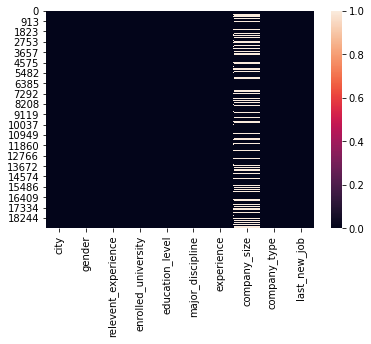

In [37]:
# Replacing Null of features with the 'most' dominant categories for features with dominant class that occupies more than 50% of the feature

categ=train.select_dtypes(include='object')

for i in mstdmnt.values:
    categ[i[1]].fillna(i[0],inplace=True)

sns.heatmap(categ.isnull())
plt.show()

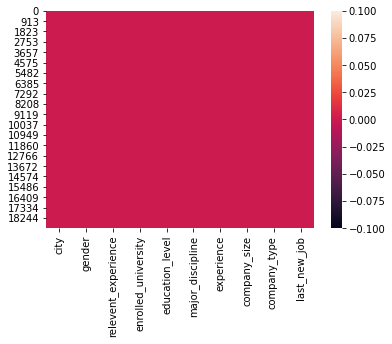

In [38]:
# Replacing null of features as 'OTHERS' for those features whose most dominant class is 'not so dominant' (ei occupy less than 50%)

for i in ndfeat: # List of features with 'not so dominant' dominant labels
    categ[i].fillna('OTHERS',inplace=True)

sns.heatmap(categ.isnull())
plt.show()

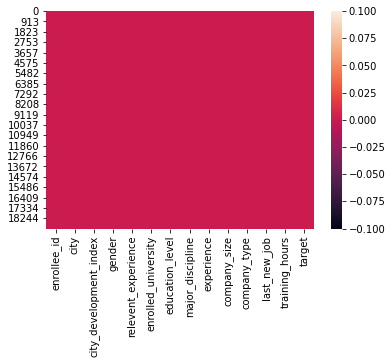

In [39]:
# Updating training set with clean categoric features
train[categ.columns]=categ

sns.heatmap(train.isnull())
plt.show()

In [40]:
train.shape

(18014, 14)

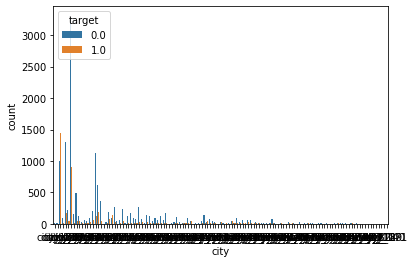

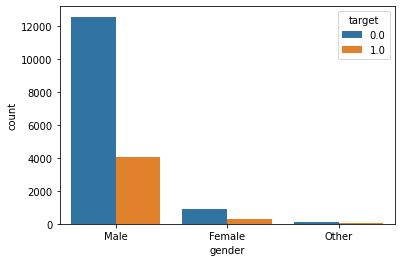

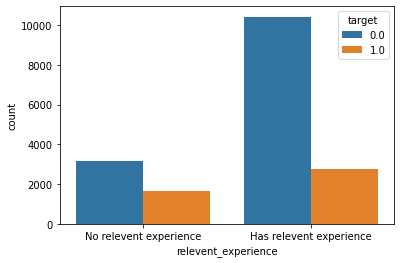

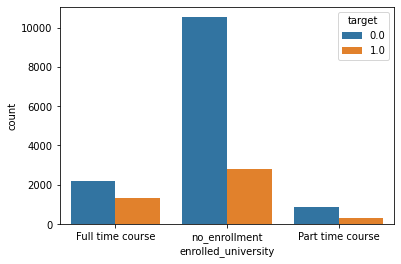

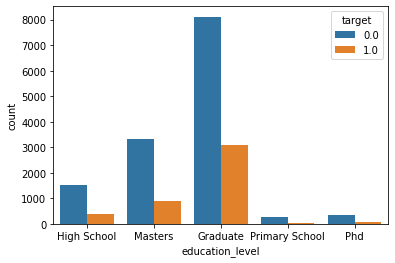

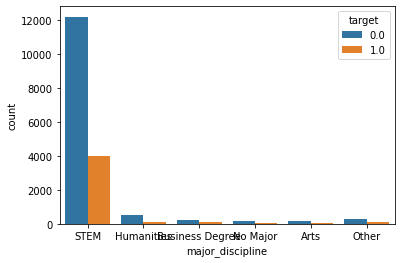

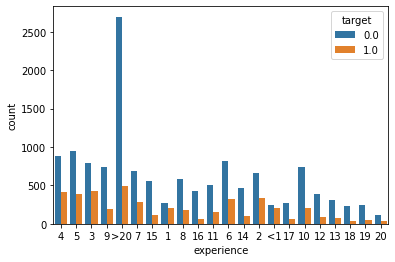

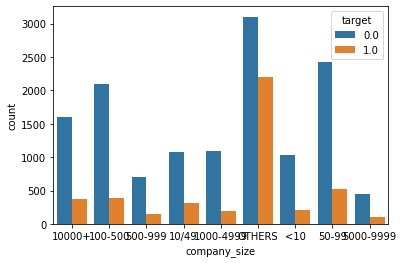

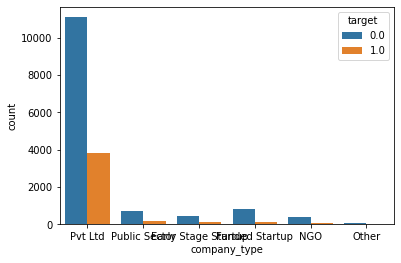

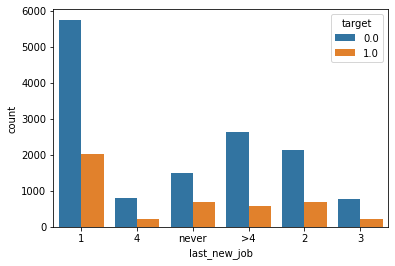

In [41]:
# Bivariate analysis of categorical features against the target
for i in categ:
    sns.countplot(categ[i],hue=train['target'])
    plt.show()

#### Collapsing categories of categoric features with many levels by Clustering

In [42]:
categ.head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
0,city_1,Male,No relevent experience,Full time course,High School,STEM,4,10000+,Pvt Ltd,1
1,city_167,Male,Has relevent experience,Full time course,Masters,STEM,5,100-500,Pvt Ltd,1
2,city_21,Female,Has relevent experience,no_enrollment,Graduate,STEM,3,10000+,Pvt Ltd,1
3,city_97,Male,Has relevent experience,Full time course,Graduate,STEM,9,100-500,Public Sector,1
4,city_16,Male,Has relevent experience,no_enrollment,Graduate,STEM,9,500-999,Pvt Ltd,4


In [43]:
categ.shape

(18014, 10)

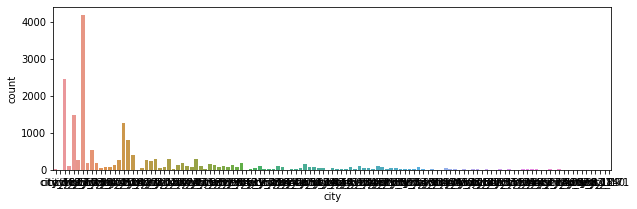

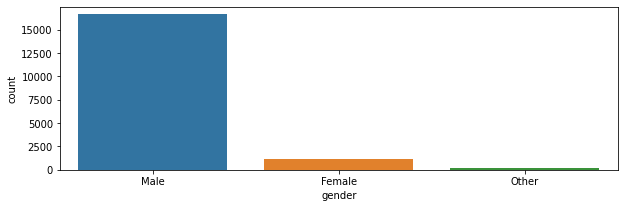

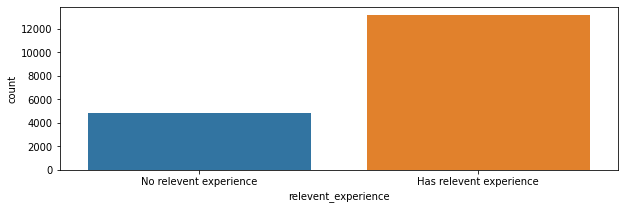

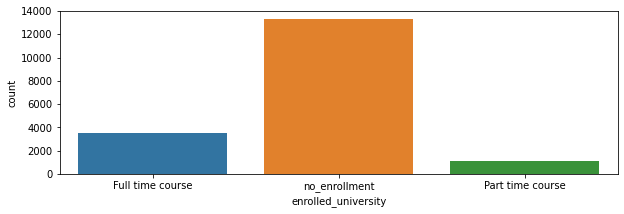

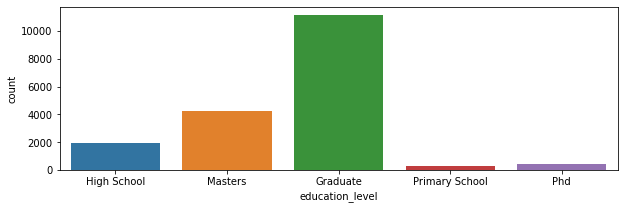

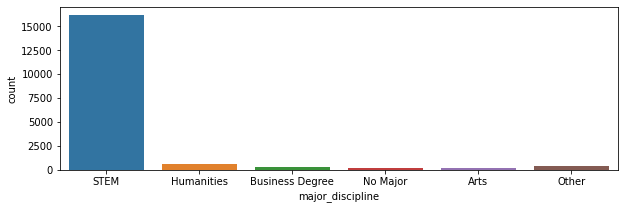

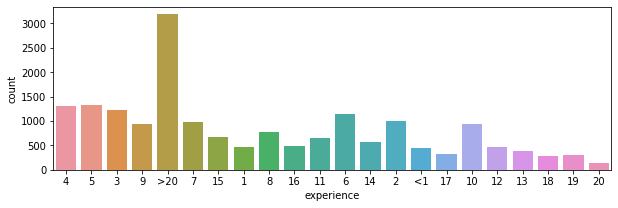

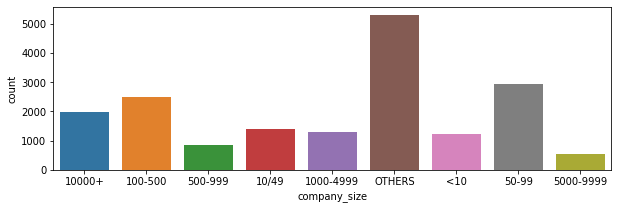

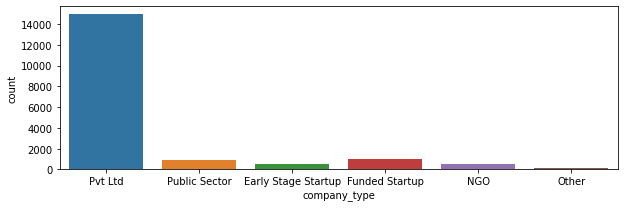

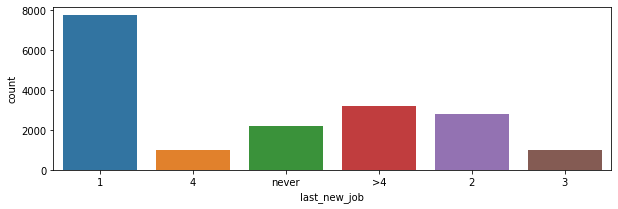

In [44]:
# Visualizing the label distributions among cateforic features
for i in categ:
    plt.figure(figsize=(10,3))
    sns.countplot(categ[i])
    plt.show()

In [45]:
desc=categ.describe()
desc

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,18014,18014,18014,18014,18014,18014,18014,18014,18014,18014
unique,123,3,2,3,5,6,22,9,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,OTHERS,Pvt Ltd,1
freq,4194,16635,13190,13348,11188,16215,3182,5310,14951,7789


In [46]:
# Checking the number of levels in each categoric feature
n_grp=pd.DataFrame(desc.iloc[1,:],index=desc.columns).rename({'unique':'Number of levels'},axis=1)
n_grp

,Number of levels
city,123
gender,3
relevent_experience,2
enrolled_university,3
education_level,5
major_discipline,6
experience,22
company_size,9
company_type,6
last_new_job,6


In [47]:
# Filtering out features with more than 6 levels
manylevelfeat=n_grp[n_grp['Number of levels']>6]

colps=list(manylevelfeat.index)   # Names of features with more than 6 levels (to be collapsed)

print(manylevelfeat)
print()
print(colps) 

             Number of levels
city                      123
experience                 22
company_size                9

['city', 'experience', 'company_size']


In [48]:
# Features to be collapsed
colps

['city', 'experience', 'company_size']

Elbow plot to check alternate number of levels to represent these feature :

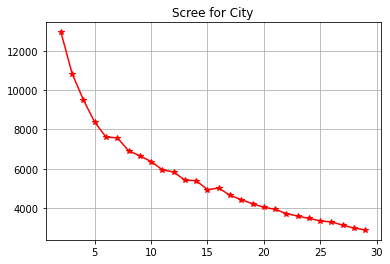

In [49]:
from sklearn.cluster import KMeans

dumcity=pd.get_dummies(categ['city'],drop_first=True)

inert_city=[]
for k in range(2,30):
    kcity=KMeans(k)
    kcity.fit(dumcity)
    
    inert_city.append(kcity.inertia_)

plt.title('Scree for City')
plt.plot(range(2,30),inert_city,color='red',marker='*')
plt.grid()
plt.show()

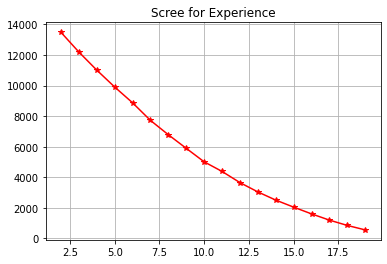

In [50]:
dumexp=pd.get_dummies(categ['experience'],drop_first=True)

inert_exp=[]
for k in range(2,20):
    kexp=KMeans(k)
    kexp.fit(dumexp)
    
    inert_exp.append(kexp.inertia_)
    
plt.title('Scree for Experience')
plt.plot(range(2,20),inert_exp,color='red',marker='*')
plt.grid()
plt.show()

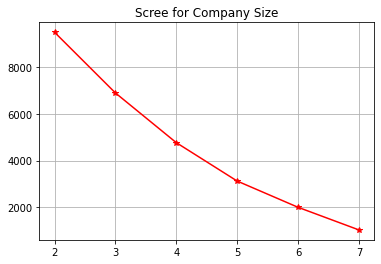

In [52]:
dumcpsize=pd.get_dummies(categ['company_size'],drop_first=True)

inert_cpsz=[]
for k in range(2,8):
    kcpsz=KMeans(k)
    kcpsz.fit(dumcpsize)
    
    inert_cpsz.append(kcpsz.inertia_)

plt.title('Scree for Company Size')
plt.plot(range(2,8),inert_cpsz,color='red',marker='*')
plt.grid()
plt.show()

Collapsing levels :

In [53]:
# Collapsed city from 123 to 15 levels
kmeancity=KMeans(n_clusters=15)
kmeancity.fit(dumcity)

city=kmeancity.labels_
city

array([8, 8, 3, ..., 1, 6, 2], dtype=int32)

In [54]:
# Collapsed experience from 22 to 10 levels
kmeanexp=KMeans(n_clusters=10)
kmeanexp.fit(dumexp)

exp=kmeanexp.labels_
exp

array([4, 6, 7, ..., 1, 0, 7], dtype=int32)

In [55]:
# Collapsed company size from 9 to 5 levels
kmeancpsize=KMeans(n_clusters=5)
kmeancpsize.fit(dumcpsize)

cpsize=kmeancpsize.labels_
cpsize

array([3, 2, 3, ..., 4, 3, 1], dtype=int32)

In [56]:
categ['city']=city
categ['experience']=exp
categ['company_size']=cpsize

categ.head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
0,8,Male,No relevent experience,Full time course,High School,STEM,4,3,Pvt Ltd,1
1,8,Male,Has relevent experience,Full time course,Masters,STEM,6,2,Pvt Ltd,1
2,3,Female,Has relevent experience,no_enrollment,Graduate,STEM,7,3,Pvt Ltd,1
3,8,Male,Has relevent experience,Full time course,Graduate,STEM,5,2,Public Sector,1
4,2,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,0,Pvt Ltd,4


In [57]:
categ[colps].head()

,city,experience,company_size
0,8,4,3
1,8,6,2
2,3,7,3
3,8,5,2
4,2,5,0


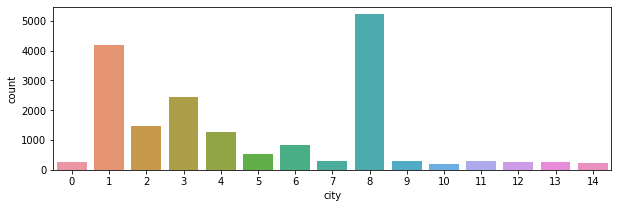

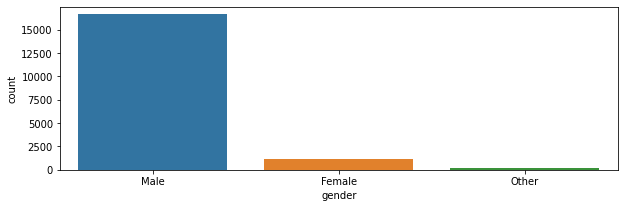

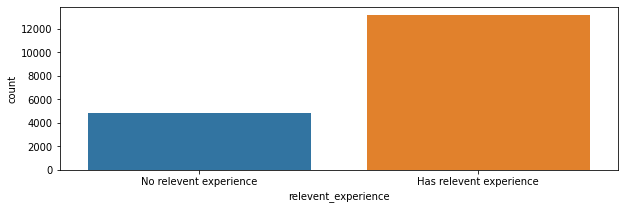

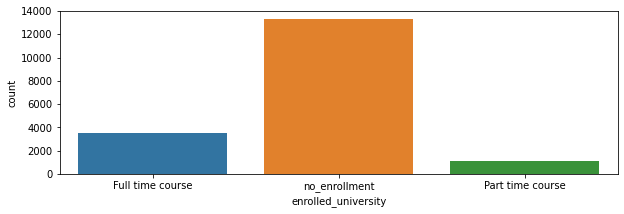

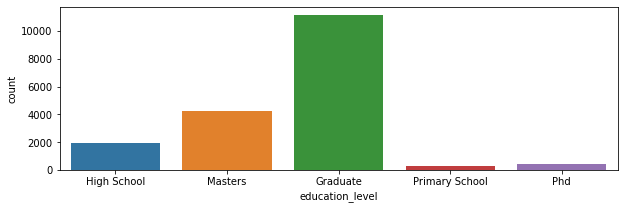

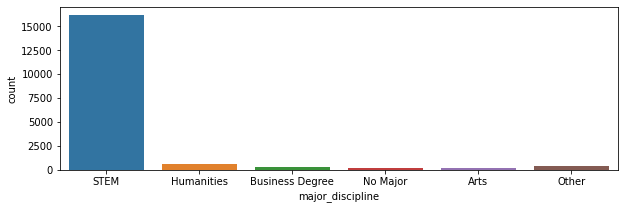

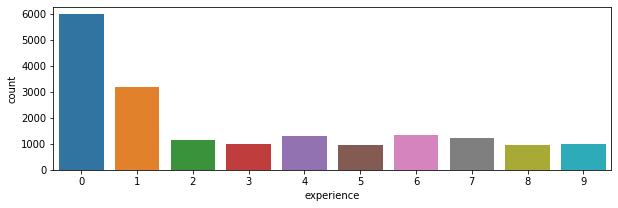

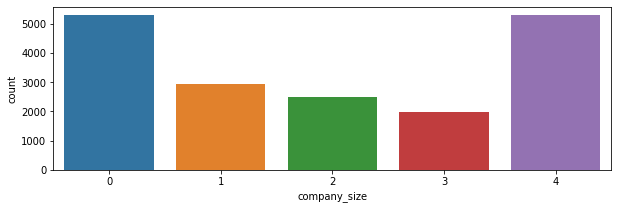

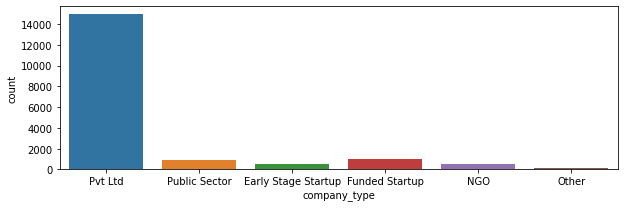

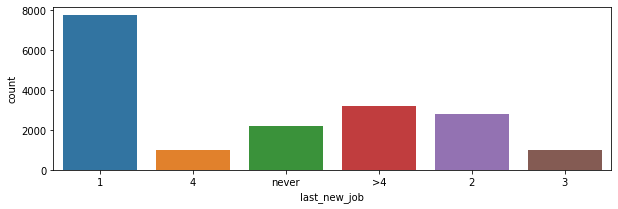

In [58]:
# Visualizing the label distributions among cateforic features after collapse (ALL categoric features included)
for i in categ:
    plt.figure(figsize=(10,3))
    sns.countplot(categ[i])
    plt.show()

In [59]:
# Final updation on the train set with collapsed features thier compressed levels
train[colps]=categ[colps]
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,20753,8,-0.244037,Male,No relevent experience,Full time course,High School,STEM,4,3,Pvt Ltd,1,1.011196,0.0
1,27035,8,0.825214,Male,Has relevent experience,Full time course,Masters,STEM,6,2,Pvt Ltd,1,-1.418698,0.0
2,21753,3,-1.569897,Female,Has relevent experience,no_enrollment,Graduate,STEM,7,3,Pvt Ltd,1,1.823295,0.0
3,27579,8,0.897221,Male,Has relevent experience,Full time course,Graduate,STEM,5,2,Public Sector,1,0.978704,0.0
4,22405,2,0.635462,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,0,Pvt Ltd,4,0.268970,0.0


In [60]:
# One-hot encoding of all categoric features of train set
train=pd.get_dummies(data=train,columns=list(categ.columns),drop_first=True)
train.head()

,enrollee_id,city_development_index,training_hours,target,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,city_13,city_14,gender_Male,gender_Other,relevent_experience_No relevent experience,enrolled_university_Part time course,enrolled_university_no_enrollment,education_level_High School,education_level_Masters,education_level_Phd,education_level_Primary School,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,experience_1,experience_2,experience_3,experience_4,experience_5,experience_6,experience_7,experience_8,experience_9,company_size_1,company_size_2,company_size_3,company_size_4,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,20753,-0.244037,1.011196,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,27035,0.825214,-1.418698,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,21753,-1.569897,1.823295,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3,27579,0.897221,0.978704,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,22405,0.635462,0.268970,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [61]:
train.shape

(18014, 55)

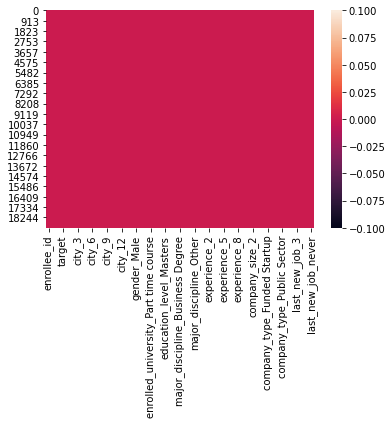

In [62]:
sns.heatmap(train.isnull())
plt.show()

### Oversampling

In [63]:
Y=train['target']
X=train.drop(['target','enrollee_id'],axis=1) # Id varibale is not going to considered

In [64]:
# Check for Data imbalance
train['target'].value_counts()

0.0    13593
1.0     4421
Name: target, dtype: int64

SMOTE

In [65]:
# Balancing data using SMOTE
from imblearn.over_sampling import SMOTE
smt=SMOTE(k_neighbors=9,random_state=10)

X,Y=smt.fit_resample(X,Y)

In [66]:
# Imbalance fixed
Y.value_counts()

AttributeError: ignored

#### MODELING

In [67]:
from sklearn.model_selection import train_test_split
Xtr,Xte,Ytr,Yte=train_test_split(X,Y,test_size=0.02,random_state=10)

Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression
log=LogisticRegression(random_state=10)
log.fit(Xtr,Ytr)

#Check for Variance:
print('Train accuracy :',log.score(Xtr,Ytr))
print('Test accuracy :',log.score(Xte,Yte))

Train accuracy : 0.7707379325876436
Test accuracy : 0.7867647058823529


In [69]:
# Check for Bais
from sklearn.model_selection import KFold,cross_val_score
cvs=cross_val_score(log,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True))
cvsrec=cross_val_score(log,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='recall')
cvsprec=cross_val_score(log,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='precision')
cvsf1=cross_val_score(log,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='f1')

print('Accuracy :',cvs)
print('Recall :',cvsrec)
print('Precision :',cvsprec)
print('F1 :',cvsf1)

Accuracy : [0.76849454 0.77513793 0.76689189]
Recall : [0.75571821 0.75515233 0.75648479]
Precision : [0.78599401 0.76894809 0.77772545]
F1 : [0.76855795 0.76591867 0.76439196]


In [70]:
# Predictions
from sklearn.model_selection import cross_val_predict
ylog=cross_val_predict(log,Xte,Yte,cv=KFold(n_splits=3,shuffle=True))
ylogprob=cross_val_predict(log,Xte,Yte,cv=KFold(n_splits=3,shuffle=True),method='predict_proba')

Naive Bayes

In [71]:
from sklearn.naive_bayes import GaussianNB
nb=GaussianNB()
nb.fit(Xtr,Ytr)

#Check for Variance:
print('Train accuracy :',nb.score(Xtr,Ytr))
print('Test accuracy :',nb.score(Xte,Yte))

Train accuracy : 0.6537422115456798
Test accuracy : 0.7095588235294118


In [72]:
# Check for Bais
cvs=cross_val_score(nb,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True))
cvsrec=cross_val_score(nb,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='recall')
cvsprec=cross_val_score(nb,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='precision')
cvsf1=cross_val_score(nb,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='f1')

print('Accuracy :',cvs)
print('Recall :',cvsrec)
print('Precision :',cvsprec)
print('F1 :',cvsf1)

Accuracy : [0.65386781 0.65702061 0.64740991]
Recall : [0.80603153 0.81003344 0.81916329]
Precision : [0.61514736 0.62154319 0.60976864]
F1 : [0.7031857  0.69928966 0.6982966 ]


In [73]:
# Predictions
ynb=cross_val_predict(nb,Xte,Yte,cv=KFold(n_splits=3,shuffle=True))
ynbprob=cross_val_predict(nb,Xte,Yte,cv=KFold(n_splits=3,shuffle=True),method='predict_proba')

Decision Tree

In [74]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(max_leaf_nodes=32,random_state=10)
dt.fit(Xtr,Ytr)

#Check for Variance:
print('Train accuracy :',dt.score(Xtr,Ytr))
print('Test accuracy :',dt.score(Xte,Yte))

Train accuracy : 0.8087606035582914
Test accuracy : 0.8180147058823529


In [75]:
# Check for Bais
cvs=cross_val_score(dt,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True))
cvsrec=cross_val_score(dt,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='recall')
cvsprec=cross_val_score(dt,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='precision')
cvsf1=cross_val_score(dt,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='f1')

print('Accuracy :',cvs)
print('Recall :',cvsrec)
print('Precision :',cvsprec)
print('F1 :',cvsf1)

Accuracy : [0.81150771 0.80204932 0.80641892]
Recall : [0.78979181 0.80530165 0.80963046]
Precision : [0.80242952 0.80649526 0.81488372]
F1 : [0.80902661 0.79875403 0.80313351]


In [76]:
# Predictions
ydt=cross_val_predict(dt,Xte,Yte,cv=KFold(n_splits=3,shuffle=True))
ydtprob=cross_val_predict(dt,Xte,Yte,cv=KFold(n_splits=3,shuffle=True),method='predict_proba')

SVC

In [78]:
from sklearn.svm import SVC
svm=SVC(probability=True)
svm.fit(Xtr,Ytr)

#Check for Variance:
print('Train accuracy :',svm.score(Xtr,Ytr))
print('Test accuracy :',svm.score(Xte,Yte))

Train accuracy : 0.8280909841603483
Test accuracy : 0.8308823529411765


In [79]:
# Check for Bais
cvs=cross_val_score(svm,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True))
cvsrec=cross_val_score(svm,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='recall')
cvsprec=cross_val_score(svm,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='precision')
cvsf1=cross_val_score(svm,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='f1')

print('Accuracy :',cvs)
print('Recall :',cvsrec)
print('Precision :',cvsprec)
print('F1 :',cvsf1)

Accuracy : [0.80790452 0.81353451 0.80135135]
Recall : [0.81064953 0.79772778 0.79874496]
Precision : [0.81886364 0.81136364 0.80352242]
F1 : [0.81338539 0.79574322 0.80758746]


In [80]:
# Predictions
ysvm=cross_val_predict(svm,Xte,Yte,cv=2)
ysvmprob=cross_val_predict(svm,Xte,Yte,cv=KFold(n_splits=3,shuffle=True),method='predict_proba')

KNN

In [81]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=7)
knn.fit(Xtr,Ytr)

#Check for Variance:
print('Train accuracy :',knn.score(Xtr,Ytr))
print('Test accuracy :',knn.score(Xte,Yte))

Train accuracy : 0.8433300803243
Test accuracy : 0.8014705882352942


In [82]:
# Check for Bais
cvs=cross_val_score(knn,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True))
cvsrec=cross_val_score(knn,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='recall')
cvsprec=cross_val_score(knn,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='precision')
cvsf1=cross_val_score(knn,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='f1')

print('Accuracy :',cvs)
print('Recall :',cvsrec)
print('Precision :',cvsprec)
print('F1 :',cvsf1)

Accuracy : [0.78741133 0.77660173 0.78231982]
Recall : [0.88726941 0.87279625 0.87082958]
Precision : [0.74820416 0.73025194 0.72658134]
F1 : [0.79696939 0.80524891 0.80012188]


In [84]:
# Predictions
yknn=cross_val_predict(knn,Xte,Yte,cv=3)
yknnprob=cross_val_predict(knn,Xte,Yte,cv=KFold(n_splits=3,shuffle=True),method='predict_proba')

ROC-AUC scores and ROC curves to select Base Model: 

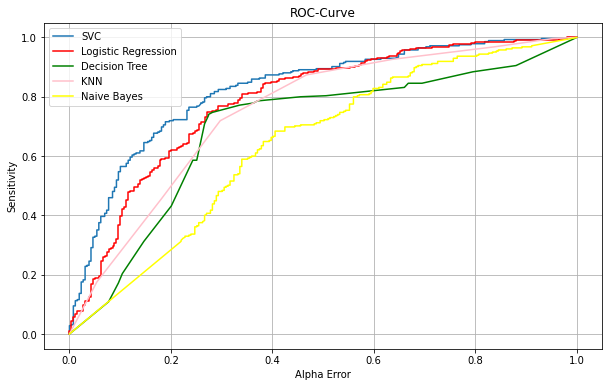

ROCAUC Logistic Regression : 0.787685429790693
ROCAUC SVC : 0.825685836212152
ROCAUC KNN : 0.7515139199349726
ROCAUC Decision Tree : 0.6949739212897108
ROCAUC Naive Bayes : 0.6425929689087584


In [85]:
from sklearn.metrics import roc_auc_score,roc_curve

plt.figure(figsize=(10,6))

# SVC:
asvm,recsvm,thsvm=roc_curve(Yte,ysvmprob[:,1])
plt.plot(asvm,recsvm,label='SVC')

# Logistic Regression:
alog,reclog,thlog=roc_curve(Yte,ylogprob[:,1])
plt.plot(alog,reclog,color='red',label='Logistic Regression')

# Decision Tree:
adt,recdt,thdt=roc_curve(Yte,ydtprob[:,1])
plt.plot(adt,recdt,color='green',label='Decision Tree')

# KNN:
aknn,recknn,thknn=roc_curve(Yte,yknnprob[:,1])
plt.plot(aknn,recknn,color='pink',label='KNN')

# Naive Bayes:
anb,recknb,thnb=roc_curve(Yte,ynbprob[:,1])
plt.plot(anb,recknb,color='yellow',label='Naive Bayes')


plt.legend()
plt.grid()
plt.title('ROC-Curve')
plt.xlabel('Alpha Error')
plt.ylabel('Sensitivity')
plt.show()

print('ROCAUC Logistic Regression :',roc_auc_score(Yte,ylogprob[:,1]))
print('ROCAUC SVC :',roc_auc_score(Yte,ysvmprob[:,1]))
print('ROCAUC KNN :',roc_auc_score(Yte,yknnprob[:,1]))
print('ROCAUC Decision Tree :',roc_auc_score(Yte,ydtprob[:,1]))
print('ROCAUC Naive Bayes :',roc_auc_score(Yte,ynbprob[:,1]))

BASEMODEL <====> Logistic Regression

In [86]:
#Hyperparameters for Randomsearch:
paramrand={'penalty':['l2','elasticnet'],
    'C':[0.07,0.5,1.0,1.5,2.0],
    'l1_ratio':[0.001,0.1,0.15,0.2,0.25,0.3,0.35,0.39,0.4,0.45,0.5,0.55],
    'tol':[0.0001,0.001,0.01,0.1],
    'class_weight':[None,'balanced'],
    'solver':['lbfgs','newton-cg', 'sag', 'saga'],
    'max_iter':[60,80,100,120,150],
    'multi_class':['auto','ovr'],
    'n_jobs':[None,-1]}

In [87]:
# Random Search CV:
from sklearn.model_selection import RandomizedSearchCV
randbase=RandomizedSearchCV(log,param_distributions=paramrand,scoring='roc_auc',cv=3,random_state=10,return_train_score=True)
randbase.fit(Xtr,Ytr)

randbase.best_params_

{'C': 1.5,
 'class_weight': 'balanced',
 'l1_ratio': 0.15,
 'max_iter': 150,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'solver': 'lbfgs',
 'tol': 0.0001}

In [88]:
randbase.best_estimator_

LogisticRegression(C=1.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.15,
                   max_iter=150, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=10, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [89]:
randbase.best_score_

0.8109283121349266

In [90]:
# Hyperparameters for fine tuning with Gridsearch:
paramgrid={'C':[3.25,3.5,3.75,3.8],  
           'l1_ratio':[0,0.002,0.005,0.009,0.01],
           'max_iter':[100,120],
          'class_weight':[None,'balanced']}

In [91]:
# Grid Search CV:
from sklearn.model_selection import GridSearchCV
gridbase=GridSearchCV(log,param_grid=paramgrid,scoring='roc_auc',cv=3)
gridbase.fit(Xtr,Ytr)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=10, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [3.25, 3.5, 3.75, 3.8],
                         'class_weight': [None, 'balanced'],
                         'l1_ratio': [0, 0.002, 0.005, 0.009, 0.01],
                         'max_iter': [100, 120]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [92]:
gridbase.best_params_

{'C': 3.25, 'class_weight': None, 'l1_ratio': 0, 'max_iter': 120}

In [93]:
gridbase.best_estimator_

LogisticRegression(C=3.25, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0, max_iter=120,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=10, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [94]:
gridbase.best_score_

0.8109323875890536

In [95]:
# Base Model
base=LogisticRegression(C=3.5, l1_ratio=0, random_state=10,class_weight='balance')
base.fit(Xtr,Ytr)

print('Train accuracy :',base.score(Xtr,Ytr))
print('Test accuracy :',base.score(Xte,Yte))

Train accuracy : 0.7707003978680279
Test accuracy : 0.7867647058823529


In [96]:
# Accuracy,precision,recall and f1 of base model
cvs=cross_val_score(base,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True))
cvsrec=cross_val_score(base,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='recall')
cvsprec=cross_val_score(base,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='precision')
cvsf1=cross_val_score(base,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='f1')

print('Accuracy :',np.mean(cvs))
print('Recall :',np.mean(cvsrec))
print('Precision :',np.mean(cvsprec))
print('F1 :',np.mean(cvsf1))

Accuracy : 0.7704750635107578
Recall : 0.7575141822529381
Precision : 0.7763671849313408
F1 : 0.7657944379267425


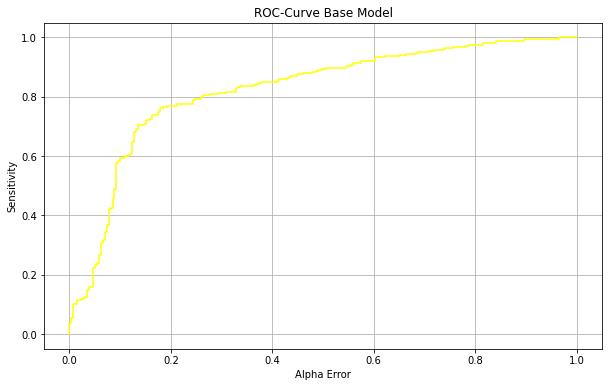

ROCAUC Base Model : 0.824033055612003


In [97]:
plt.figure(figsize=(10,6))

abase,recbase,thbase=roc_curve(Yte,base.predict_proba(Xte)[:,-1])

plt.plot(abase,recbase,color='yellow')

plt.grid()
plt.title('ROC-Curve Base Model')
plt.xlabel('Alpha Error')
plt.ylabel('Sensitivity')
plt.show()

print('ROCAUC Base Model :',roc_auc_score(Yte,base.predict_proba(Xte)[:,-1]))

In [100]:
from mlxtend.feature_selection import SequentialFeatureSelector
sfs=SequentialFeatureSelector(base,forward=False,k_features=5,cv=2)
sfs.fit(X,Y)

SequentialFeatureSelector(clone_estimator=True, cv=2,
                          estimator=LogisticRegression(C=3.5,
                                                       class_weight='balance',
                                                       dual=False,
                                                       fit_intercept=True,
                                                       intercept_scaling=1,
                                                       l1_ratio=0, max_iter=100,
                                                       multi_class='auto',
                                                       n_jobs=None,
                                                       penalty='l2',
                                                       random_state=10,
                                                       solver='lbfgs',
                                                       tol=0.0001, verbose=0,
                                                       warm_start=False),

In [101]:
# Important features:
sfs.k_feature_names_

('0', '2', '4', '7', '42')

### Ensemble

Random Forest

In [106]:
from sklearn.ensemble import RandomForestClassifier

In [107]:
paramrand={'n_estimators':[300,100,150],
    'criterion':['gini','entropy'],
    'max_depth':[5,7,8,9,10,12],
    'max_leaf_nodes':range(8,33),
    'min_samples_split':[2,5,7,9,20,100],
    'min_samples_leaf':[1,2],
    'min_weight_fraction_leaf':[0.0,0.01,2,5,10],
    'max_features':['auto', 'sqrt', 'log2'],
    'min_impurity_decrease':[0.0,0.001,2,5,10],
    'min_impurity_split':[0.0,0.001,2,5,10],
    'oob_score':[False,True],
    'class_weight':[None,1,2,5,10,0,0.1],
    'ccp_alpha':[1,2,5,10,0,0.10],
    'max_samples':[None,1,400]}

In [108]:
randrf=RandomizedSearchCV(RandomForestClassifier(),param_distributions=paramrand,scoring='roc_auc')
randrf.fit(Xtr,Ytr)

randrf.best_params_

{'ccp_alpha': 5,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': 15,
 'max_samples': 400,
 'min_impurity_decrease': 2,
 'min_impurity_split': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 9,
 'min_weight_fraction_leaf': 0.01,
 'n_estimators': 150,
 'oob_score': True}

In [110]:
randrf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=5, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='sqrt',
                       max_leaf_nodes=15, max_samples=400,
                       min_impurity_decrease=2, min_impurity_split=2,
                       min_samples_leaf=2, min_samples_split=9,
                       min_weight_fraction_leaf=0.01, n_estimators=150,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [111]:
rf=RandomForestClassifier(max_leaf_nodes=32,max_depth=10,n_estimators=180,min_samples_leaf=2,
                          min_samples_split=2,min_impurity_split=0.0,criterion='gini',random_state=10)

rf.fit(Xtr,Ytr)

# Check for Variance
# Check for Variance
print('Train accuracy :',rf.score(Xtr,Ytr))
print('Test accuracy :',rf.score(Xte,Yte))

Train accuracy : 0.8033180692140229
Test accuracy : 0.8198529411764706


In [112]:
# Check for Bais
cvs=cross_val_score(rf,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True))
cvsrec=cross_val_score(rf,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='recall')
cvsprec=cross_val_score(rf,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='precision')
cvsf1=cross_val_score(rf,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='f1')

print('Accuracy :',cvs)
print('Recall :',cvsrec)
print('Precision :',cvsprec)
print('F1 :',cvsf1)

Accuracy : [0.79202792 0.80790452 0.80101351]
Recall : [0.80937288 0.80113507 0.80962996]
Precision : [0.79650273 0.79844444 0.79168539]
F1 : [0.80833701 0.80139766 0.79864177]


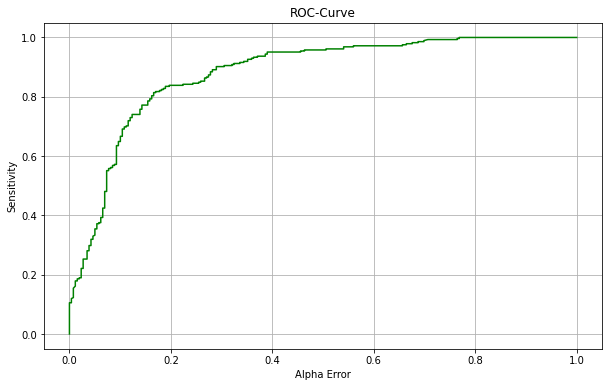

ROCAUC Random Forest : 0.8803224276908487


In [113]:
plt.figure(figsize=(10,6))

arf,recrf,thrf=roc_curve(Yte,rf.predict_proba(Xte)[:,1])

plt.plot(arf,recrf,color='green')

plt.grid()
plt.title('ROC-Curve')
plt.xlabel('Alpha Error')
plt.ylabel('Sensitivity')
plt.show()

print('ROCAUC Random Forest :',roc_auc_score(Yte,rf.predict_proba(Xte)[:,1]))

XGBoost

In [114]:
from xgboost import XGBClassifier

In [115]:
# Random Search
paramrand={'n_estimators':[70,100,130,150,180,200],
          'max_depth': [4,6,8,10,12],
          'learning_rate':['eta',0.5,0.1,0.05,0.8,1,1.3,1.5,2],
          'gamma': [0,0.001,0.03,0.05,0.07,0.1,0.2],
          'min_child_weight':[1,3,5,7],
          'colsample_bytree':[0.3,0.4,0.5,0.7],
          'booster':['gbtree', 'dart'], 
          'importance_type':['gain', 'weight', 'cover', 'total_gain','total_cover']}

In [116]:
randxgb=RandomizedSearchCV(XGBClassifier(eval_metric='error',random_state=10),param_distributions=paramrand,scoring='roc_auc',n_iter=12)
randxgb.fit(Xtr,Ytr)

randxgb.best_score_

0.9298676914710781

In [117]:
randxgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eval_metric='error',
              gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=7, missing=None, n_estimators=180, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [119]:
randxgb.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.4,
 'gamma': 0.2,
 'importance_type': 'total_cover',
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 7,
 'n_estimators': 180}

In [120]:
xgb=XGBClassifier(n_estimators=150,max_depth=8,colsample_bytree=0.3,booster='gbtree',
                  min_child_weight=7,learning_rate=0.8,gamma=0.03,importance_type='cover',
                  eval_metric='error',random_state=10,)
xgb.fit(Xtr,Ytr)

# Check for Variance
print('Train accuracy :',xgb.score(Xtr,Ytr))
print('Test accuracy :',xgb.score(Xte,Yte))

Train accuracy : 0.9028226109150964
Test accuracy : 0.8878676470588235


In [121]:
# Check for Bais
cvs=cross_val_score(xgb,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True))
cvsrec=cross_val_score(xgb,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='recall')
cvsprec=cross_val_score(xgb,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='precision')
cvsf1=cross_val_score(xgb,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='f1')

print('Accuracy :',cvs)
print('Recall :',cvsrec)
print('Precision :',cvsprec)
print('F1 :',cvsf1)

Accuracy : [0.84844049 0.85103029 0.84808559]
Recall : [0.83130631 0.83686489 0.83054253]
Precision : [0.84445478 0.87091615 0.85804343]
F1 : [0.84701874 0.84745376 0.84964636]


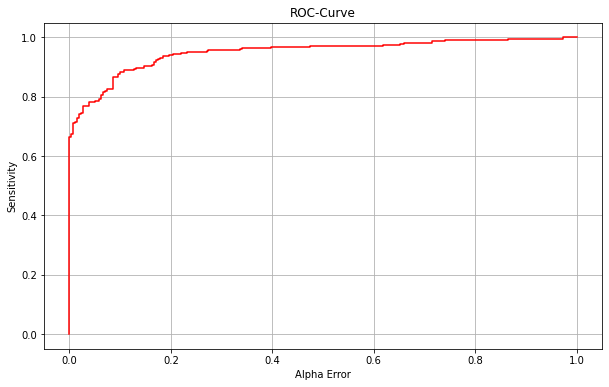

ROCAUC XGBoost : 0.9506468874889926


In [122]:
plt.figure(figsize=(10,6))

axgb,recxgb,thxgb=roc_curve(Yte,xgb.predict_proba(Xte)[:,1])

plt.plot(axgb,recxgb,color='red')

plt.grid()
plt.title('ROC-Curve')
plt.xlabel('Alpha Error')
plt.ylabel('Sensitivity')
plt.show()

print('ROCAUC XGBoost :',roc_auc_score(Yte,xgb.predict_proba(Xte)[:,1]))

Model Comparison to select final model

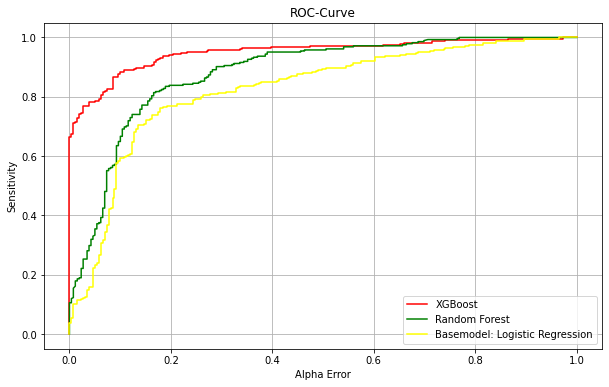

ROCAUC XGBoost : 0.9506468874889926
ROCAUC Random Forest : 0.8803224276908487
ROCAUC Base Model : 0.824033055612003


In [123]:
plt.figure(figsize=(10,6))

axgb,recxgb,thxgb=roc_curve(Yte,xgb.predict_proba(Xte)[:,1])
plt.plot(axgb,recxgb,color='red',label='XGBoost')

arf,recrf,thrf=roc_curve(Yte,rf.predict_proba(Xte)[:,1])
plt.plot(arf,recrf,color='green',label='Random Forest')

abase,recbase,thbase=roc_curve(Yte,base.predict_proba(Xte)[:,-1])
plt.plot(abase,recbase,color='yellow',label='Basemodel: Logistic Regression')

plt.grid()
plt.legend()
plt.title('ROC-Curve')
plt.xlabel('Alpha Error')
plt.ylabel('Sensitivity')
plt.show()

print('ROCAUC XGBoost :',roc_auc_score(Yte,xgb.predict_proba(Xte)[:,1]))
print('ROCAUC Random Forest :',roc_auc_score(Yte,rf.predict_proba(Xte)[:,1]))
print('ROCAUC Base Model :',roc_auc_score(Yte,base.predict_proba(Xte)[:,-1]))

Final Model <====> XGBoost Classifier

In [124]:
final=XGBClassifier(n_estimators=160,max_depth=8,colsample_bytree=0.3,booster='gbtree',
                  min_child_weight=5,learning_rate=0.5,gamma=0.5,importance_type='total_cover',
                  eval_metric='error',random_state=10,)
final.fit(X,Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='error',
              gamma=0.5, learning_rate=0.5, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=None, n_estimators=160, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# Test Set

In [128]:
test = pd.read_csv('/content/gdrive/MyDrive/Springboard-master/Capstone 3/aug_test.csv')
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [129]:
test.shape

(2129, 13)

In [130]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


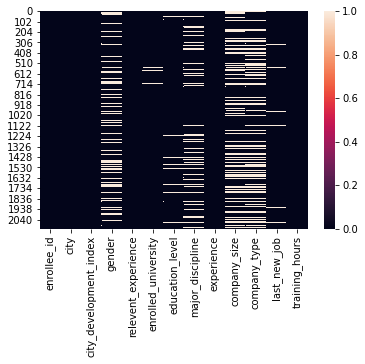

In [131]:
sns.heatmap(test.isnull())
plt.show()

In [132]:
propnulltest=100*(test.isnull().sum()/len(test))
propnulltest

enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    23.860968
relevent_experience        0.000000
enrolled_university        1.456083
education_level            2.442461
major_discipline          14.654767
experience                 0.234852
company_size              29.215594
company_type              29.779239
last_new_job               1.878816
training_hours             0.000000
dtype: float64

In [133]:
subtest=list(propnulltest[(propnulltest<10) & (propnulltest>0)].index)
test.dropna(subset=subtest,inplace=True)
test.shape

(2018, 13)

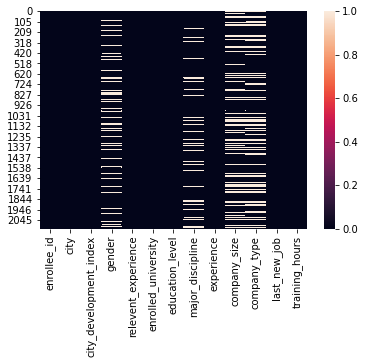

In [134]:
sns.heatmap(test.isnull())
plt.show()

In [135]:
# Numeric data
numtest=test.select_dtypes(include='number').drop('enrollee_id',axis=1)
numtest.head()

,city_development_index,training_hours
0,0.827,21
1,0.920,98
2,0.624,15
3,0.827,39
4,0.920,72


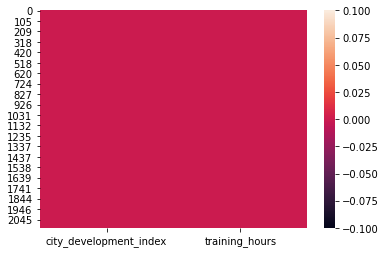

In [136]:
sns.heatmap(numtest.isnull())
plt.show()

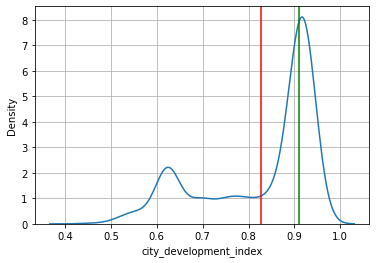

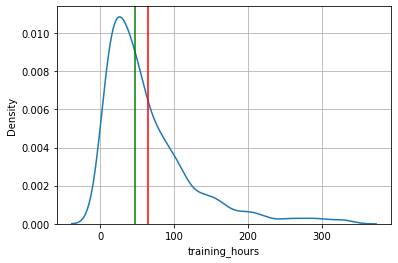

In [137]:
for i in numtest:
    sns.distplot(numtest[i],hist=False)
    plt.axvline(np.mean(numtest[i]),color='red')
    plt.axvline(np.median(numtest[i]),color='green')
    plt.grid()
    plt.show()

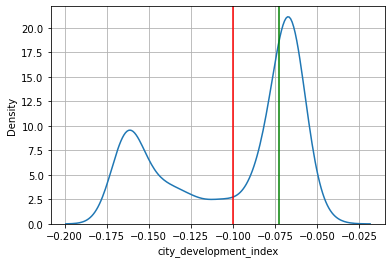

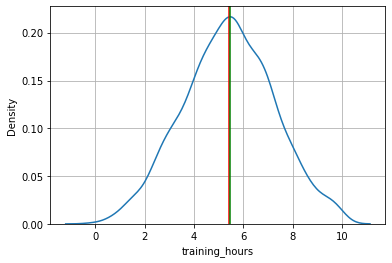

In [138]:
# Trying boxcox transform:
import scipy.stats as stats
for i in numtest:
    sns.distplot(stats.boxcox(numtest[i])[0],hist=False)
    plt.axvline(np.mean(stats.boxcox(numtest[i])[0]),color='red')
    plt.axvline(np.median(stats.boxcox(numtest[i])[0]),color='green')
    
    plt.xlabel(i)
    plt.grid()
    plt.show()

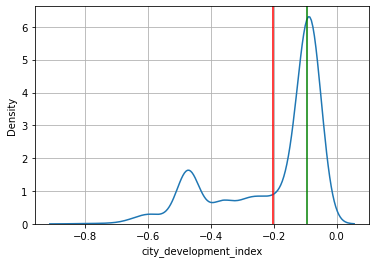

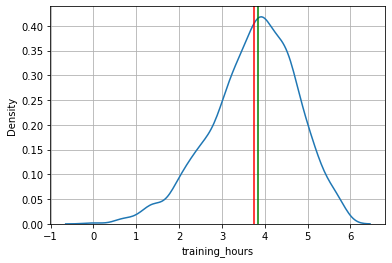

In [139]:
# Trying Log tranformation on the numeric features to check skewness and distribution
for i in numtest:
    sns.distplot(np.log(numtest[i]),hist=False)
    plt.axvline(np.mean(np.log(numtest[i])),color='red')
    plt.axvline(np.median(np.log(numtest[i])),color='green')
    
    plt.xlabel(i)
    plt.grid()
    plt.show()

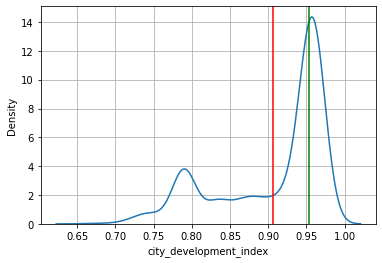

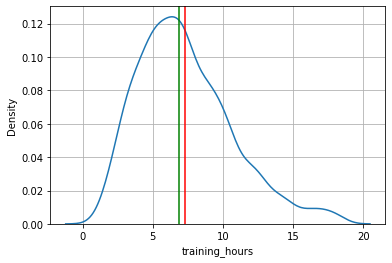

In [140]:
# Trying sqrt tranformation on the numeric features to check skewness and distribution
for i in numtest:
    sns.distplot(np.sqrt(numtest[i]),hist=False)
    plt.axvline(np.mean(np.sqrt(numtest[i])),color='red')
    plt.axvline(np.median(np.sqrt(numtest[i])),color='green')
    
    plt.xlabel(i)
    plt.grid()
    plt.show()

In [141]:
# Transforming numeric test data using boxcox
for i in numtest:
    numtest[i]=stats.boxcox(numtest[i])[0]
numtest.head()

,city_development_index,training_hours
0,-0.115672,3.991609
1,-0.066268,6.952814
2,-0.162621,3.441983
3,-0.115672,5.089015
4,-0.066268,6.296315


In [142]:
# Updating these transformations onto the test set
for i in numtest:
    test[i]=numtest[i]
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,-0.115672,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,3.991609
1,9858,city_103,-0.066268,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,6.952814
2,31806,city_21,-0.162621,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,3.441983
3,27385,city_13,-0.115672,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,5.089015
4,27724,city_103,-0.066268,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,6.296315


In [143]:
# Scalling these transformed numeric features
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

test[numtest.columns]=sc.fit_transform(test[numtest.columns])
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,-0.381734,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,-0.769930
1,9858,city_103,0.826549,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,0.838316
2,31806,city_21,-1.529930,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,-1.068434
3,27385,city_13,-0.381734,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,-0.173923
4,27724,city_103,0.826549,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,0.481768


In [144]:
test.shape

(2018, 13)

In [145]:
100*(test.isnull().sum()/len(test))

enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    21.952428
relevent_experience        0.000000
enrolled_university        0.000000
education_level            0.000000
major_discipline          12.338949
experience                 0.000000
company_size              28.592666
company_type              28.691774
last_new_job               0.000000
training_hours             0.000000
dtype: float64

In [146]:
# Categoric Data
categtest=test.select_dtypes(include='object')
categtest.head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
0,city_41,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1
1,city_103,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1
2,city_21,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never
3,city_13,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1
4,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4


In [147]:
categtest.shape

(2018, 10)

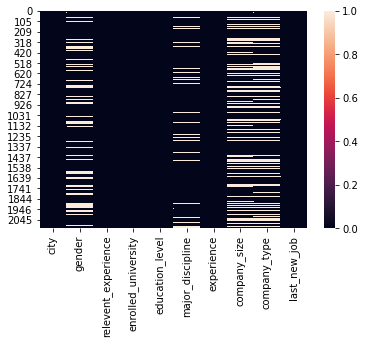

In [148]:
sns.heatmap(categtest.isnull())
plt.show()

In [149]:
propnctest=categtest.isnull().sum()/len(test)
propnctest

city                   0.000000
gender                 0.219524
relevent_experience    0.000000
enrolled_university    0.000000
education_level        0.000000
major_discipline       0.123389
experience             0.000000
company_size           0.285927
company_type           0.286918
last_new_job           0.000000
dtype: float64

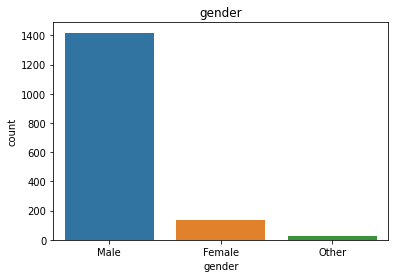

        Proportion % 
Male        70.267592
Female       6.640238
Other        1.139742


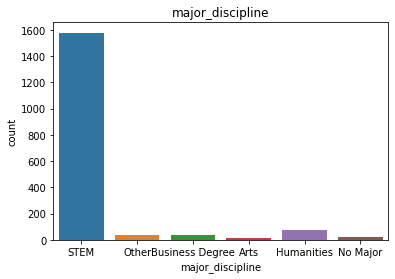

                 Proportion % 
STEM                 78.146680
Humanities            3.914767
Other                 1.932607
Business Degree       1.833499
No Major              0.991080
Arts                  0.842418


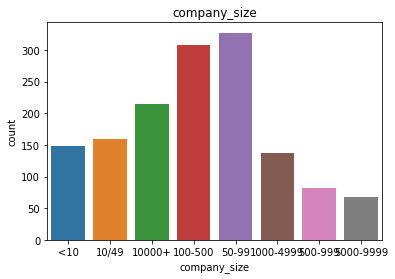

           Proportion % 
50-99          16.204163
100-500        15.213082
10000+         10.604559
10/49           7.879088
<10             7.333994
1000-4999       6.788900
500-999         4.063429
5000-9999       3.320119


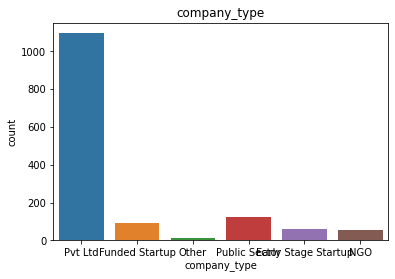

                     Proportion % 
Pvt Ltd                  54.261645
Public Sector             6.144698
Funded Startup            4.658077
Early Stage Startup       3.072349
NGO                       2.626363
Other                     0.545094


In [150]:
# Univariate analysis on categoric features with more than 10% null values
# Percentage Proportion of categoric groups in the feature with null>10% for identiying dominant groups

nctest=propnctest[propnctest>0.1].index # Index of categoric features with more than 10% null values
for i in nctest:
    plt.title(i)
    sns.countplot(categtest[i])
    plt.show()
    a=100*categtest[i].value_counts()/len(categtest)
    a=pd.DataFrame(a).rename({i:'Proportion % '},axis=1)
    print(a)

In [151]:
# Identifying the most Dominant categories in each feature dominating more than 50% of the total counts of that feature

domintest=[] # List of the most Dominant categories in each feature dominating more than 50% of the total counts of that feature
dfeattest=[] # Features associated with these 'most' dominant categories

ndfeattest=[] # Features that had most dominant category not being so dominant (less than 50%) 

for i in nctest:                    # nc is the index of categorical features with >10% null
    maxitest=categtest[i].value_counts().max()    # Count of the most dominant group
    domtest=categtest[i].value_counts().idxmax()  # Most dominant group in the feature
    
    if maxitest/len(categtest)>=0.5:    # Filtering out ONLY those dominant categories that dominate >=50% proportion in that feature
        domintest.append(domtest)
        dfeattest.append(i)
    else:
        ndfeattest.append(i)
        
mstdmnttest=pd.DataFrame({'Most Dominant Categories':domintest,'Feature':dfeattest}) # Tabular representation of dominant categories and the features that contain them
print(mstdmnttest)
print()
print('Features with not so dominant labels: ',ndfeattest) # List of features with 'not so dominant' dominant labels

  Most Dominant Categories           Feature
0                     Male            gender
1                     STEM  major_discipline
2                  Pvt Ltd      company_type

Features with not so dominant labels:  ['company_size']


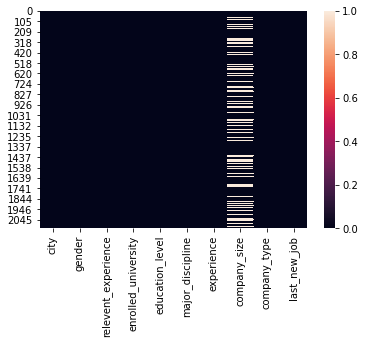

In [152]:
# Replacing Null of features with the 'most' dominant categories for features with dominant class that occupies more than 50% of the feature

categtest=test.select_dtypes(include='object')

for i in mstdmnttest.values:
    categtest[i[1]].fillna(i[0],inplace=True)

sns.heatmap(categtest.isnull())
plt.show()

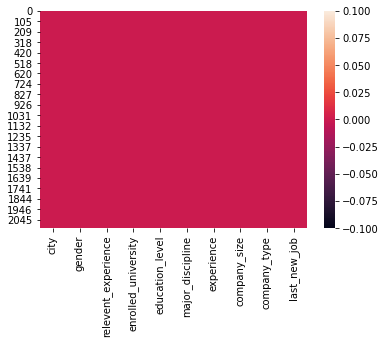

In [153]:
# Replacing null of features as 'OTHERS' for those features whose most dominant class is 'not so dominant' (ei occupy less than 50%)

for i in ndfeattest: # List of features with 'not so dominant' dominant labels
    categtest[i].fillna('OTHERS',inplace=True)

sns.heatmap(categtest.isnull())
plt.show()

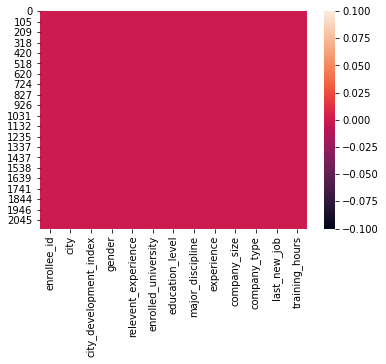

In [154]:
# Updating test set with clean categoric features
test[categtest.columns]=categtest

sns.heatmap(test.isnull())
plt.show()

In [155]:
test.shape

(2018, 13)

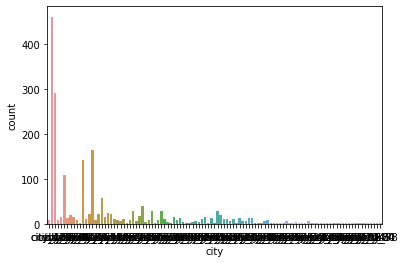

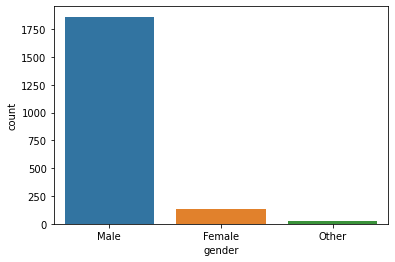

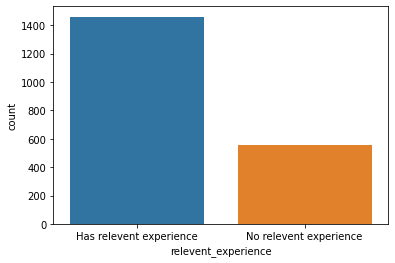

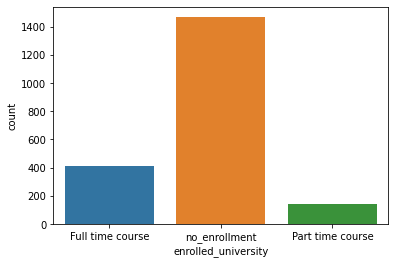

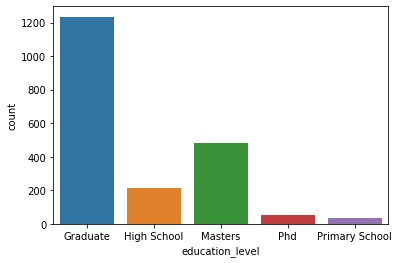

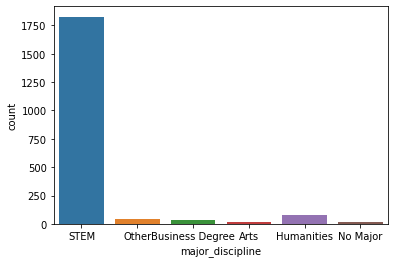

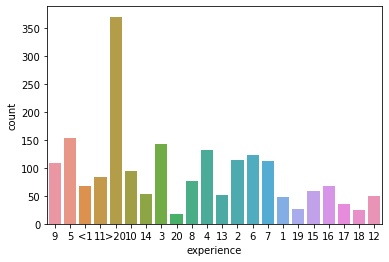

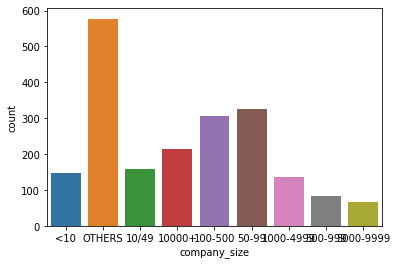

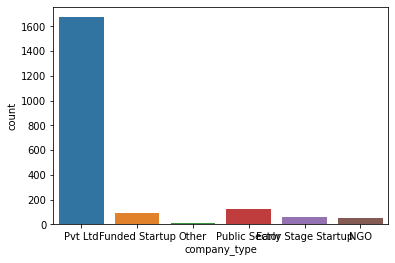

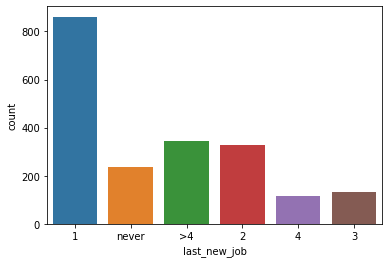

In [156]:
# Univariate analysis of all categorical features to get an idea of number of levels
for i in categtest:
    sns.countplot(categtest[i])
    plt.show()

In [157]:
desctest=categtest.describe()
desctest

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018
unique,107,3,2,3,5,6,22,9,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,OTHERS,Pvt Ltd,1
freq,461,1861,1460,1469,1234,1826,371,577,1674,861


In [158]:
# Number of levels in each category
n_grptest=pd.DataFrame(desctest.iloc[1,:],index=desctest.columns).rename({'unique':'Number of levels'},axis=1)
n_grptest

,Number of levels
city,107
gender,3
relevent_experience,2
enrolled_university,3
education_level,5
major_discipline,6
experience,22
company_size,9
company_type,6
last_new_job,6


In [159]:
# Filtering out features with more than 6 levels
manylevelfeattest=n_grptest[n_grptest['Number of levels']>6]

colpstest=list(manylevelfeattest.index)   # Names of features with more than 6 levels (to be collapsed)

print(manylevelfeattest)
print()
print('Features to be collapsed:',colpstest) 

             Number of levels
city                      107
experience                 22
company_size                9

Features to be collapsed: ['city', 'experience', 'company_size']


 Elbow plot to check alternate number of levels to represent these feature :

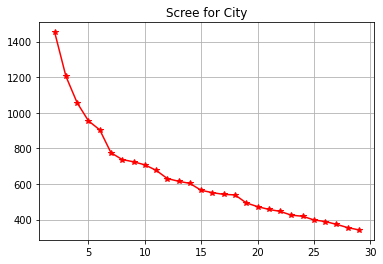

In [160]:
from sklearn.cluster import KMeans

dumcitytest=pd.get_dummies(categtest['city'],drop_first=True)

inert_citytest=[]
for k in range(2,30):
    kcitytest=KMeans(k)
    kcitytest.fit(dumcitytest)
    
    inert_citytest.append(kcitytest.inertia_)

plt.title('Scree for City')
plt.plot(range(2,30),inert_citytest,color='red',marker='*')
plt.grid()
plt.show()

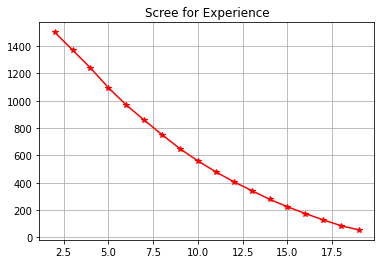

In [161]:
dumexptest=pd.get_dummies(categtest['experience'],drop_first=True)

inert_exptest=[]
for k in range(2,20):
    kexptest=KMeans(k)
    kexptest.fit(dumexptest)
    
    inert_exptest.append(kexptest.inertia_)
    
plt.title('Scree for Experience')
plt.plot(range(2,20),inert_exptest,color='red',marker='*')
plt.grid()
plt.show()

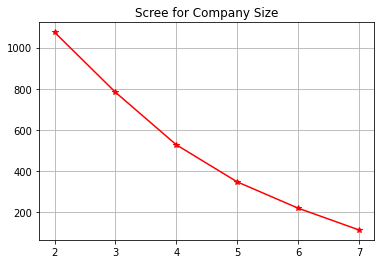

In [162]:
dumcpsizetest=pd.get_dummies(categtest['company_size'],drop_first=True)

inert_cpsztest=[]
for k in range(2,8):
    kcpsztest=KMeans(k)
    kcpsztest.fit(dumcpsizetest)
    
    inert_cpsztest.append(kcpsztest.inertia_)

plt.title('Scree for Company Size')
plt.plot(range(2,8),inert_cpsztest,color='red',marker='*')
plt.grid()
plt.show()

In [163]:
# Collapsed city from 107 to 15 levels
kmeancitytest=KMeans(n_clusters=15)
kmeancitytest.fit(dumcitytest)

citytest=kmeancitytest.labels_
citytest

array([ 0,  1,  2, ...,  0, 13, 13], dtype=int32)

In [164]:
# Collapsed experience from 22 to 10 levels
kmeanexptest=KMeans(n_clusters=10)
kmeanexptest.fit(dumexptest)

exptest=kmeanexptest.labels_
exptest

array([9, 2, 7, ..., 6, 8, 7], dtype=int32)

In [165]:
# Collapsed company size from 9 to 5 levels
kmeancpsizetest=KMeans(n_clusters=5)
kmeancpsizetest.fit(dumcpsizetest)

cpsizetest=kmeancpsizetest.labels_
cpsizetest

array([0, 1, 1, ..., 1, 3, 4], dtype=int32)

In [166]:
categtest['city']=citytest
categtest['experience']=exptest
categtest['company_size']=cpsizetest

categtest.head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
0,0,Male,Has relevent experience,Full time course,Graduate,STEM,9,0,Pvt Ltd,1
1,1,Female,Has relevent experience,no_enrollment,Graduate,STEM,2,1,Pvt Ltd,1
2,2,Male,No relevent experience,no_enrollment,High School,STEM,7,1,Pvt Ltd,never
3,0,Male,Has relevent experience,no_enrollment,Masters,STEM,7,0,Pvt Ltd,1
4,1,Male,Has relevent experience,no_enrollment,Graduate,STEM,1,4,Pvt Ltd,>4


In [167]:
categtest[colpstest].head()

,city,experience,company_size
0,0,9,0
1,1,2,1
2,2,7,1
3,0,7,0
4,1,1,4


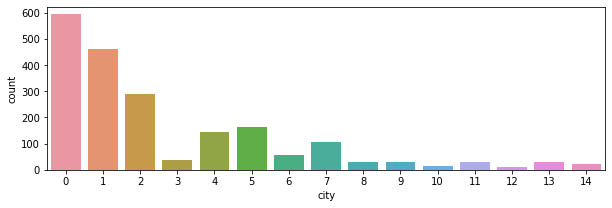

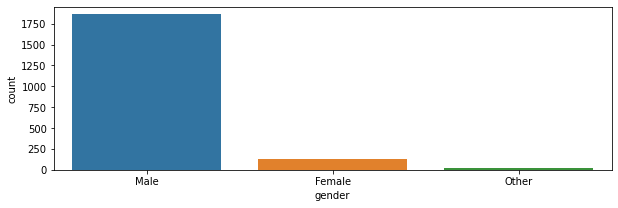

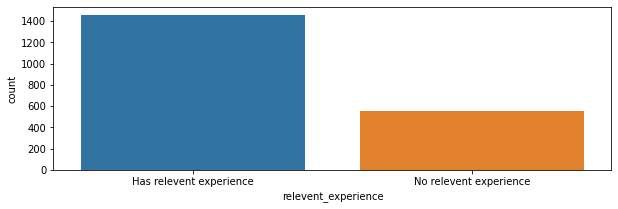

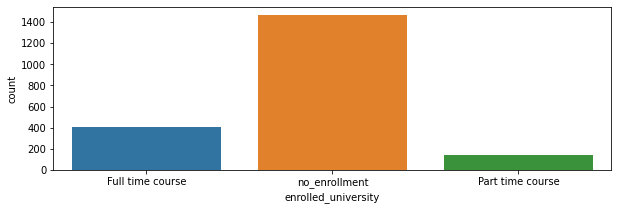

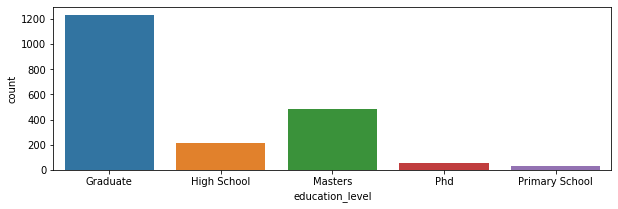

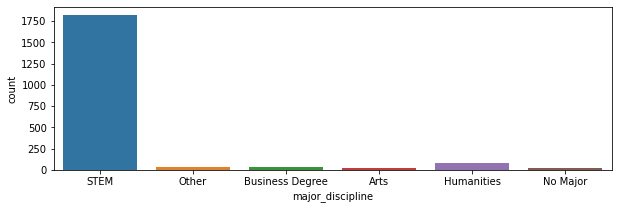

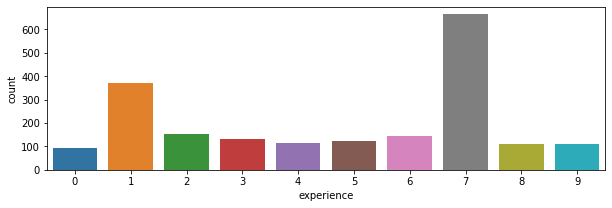

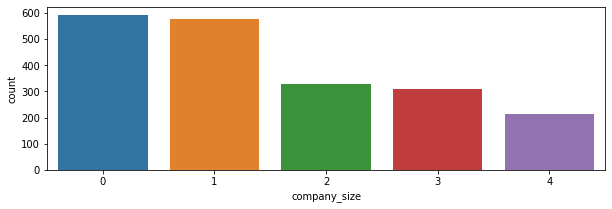

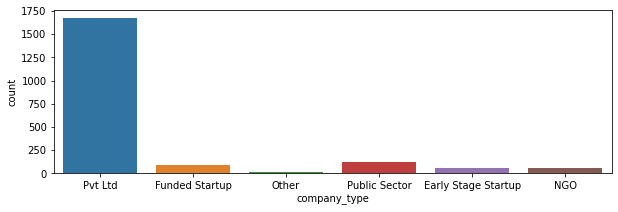

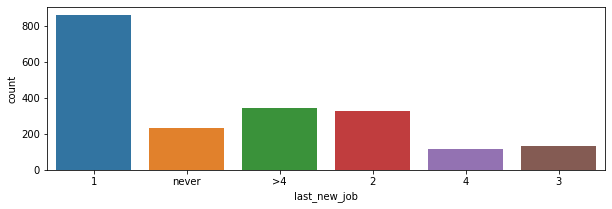

In [168]:
# Visualizing the label distributions among cateforic features after collapse (ALL categoric features included)
for i in categtest:
    plt.figure(figsize=(10,3))
    sns.countplot(categtest[i])
    plt.show()

In [169]:
# Final updation on the test set with collapsed features thier compressed levels
test[colpstest]=categtest[colpstest]
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,0,-0.381734,Male,Has relevent experience,Full time course,Graduate,STEM,9,0,Pvt Ltd,1,-0.769930
1,9858,1,0.826549,Female,Has relevent experience,no_enrollment,Graduate,STEM,2,1,Pvt Ltd,1,0.838316
2,31806,2,-1.529930,Male,No relevent experience,no_enrollment,High School,STEM,7,1,Pvt Ltd,never,-1.068434
3,27385,0,-0.381734,Male,Has relevent experience,no_enrollment,Masters,STEM,7,0,Pvt Ltd,1,-0.173923
4,27724,1,0.826549,Male,Has relevent experience,no_enrollment,Graduate,STEM,1,4,Pvt Ltd,>4,0.481768


In [170]:
# One-hot encoding of all categoric features of test set
test=pd.get_dummies(data=test,columns=list(categtest.columns),drop_first=True)
test.head()

,enrollee_id,city_development_index,training_hours,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,city_13,city_14,gender_Male,gender_Other,relevent_experience_No relevent experience,enrolled_university_Part time course,enrolled_university_no_enrollment,education_level_High School,education_level_Masters,education_level_Phd,education_level_Primary School,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,experience_1,experience_2,experience_3,experience_4,experience_5,experience_6,experience_7,experience_8,experience_9,company_size_1,company_size_2,company_size_3,company_size_4,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,32403,-0.381734,-0.769930,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,9858,0.826549,0.838316,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,31806,-1.529930,-1.068434,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
3,27385,-0.381734,-0.173923,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,27724,0.826549,0.481768,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0


In [171]:
test.shape

(2018, 54)

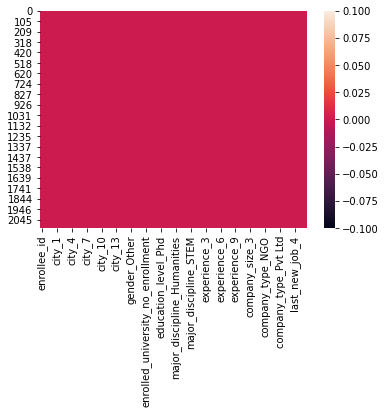

In [172]:
sns.heatmap(test.isnull())
plt.show()

# Final Predictions using the Final Model

In [173]:
Xtest=test.drop('enrollee_id',axis=1)
Ypred=final.predict(Xtest)
Ypred

ValueError: ignored

In [174]:
len(Ypred)==len(test)

NameError: ignored

In [175]:
# Important Features:
impo=pd.DataFrame(final.feature_importances_,index=Xtest.columns,columns=['Importance']).sort_values(by=['Importance'],ascending=False)
impo

,Importance
training_hours,0.171947
city_development_index,0.084368
education_level_Primary School,0.026288
company_size_4,0.025167
education_level_Masters,0.020855
last_new_job_2,0.020101
last_new_job_>4,0.019507
experience_5,0.018954
relevent_experience_No relevent experience,0.018118
last_new_job_never,0.018056
